In [301]:
NUMBER_OF_EPOCH = 50000

In [302]:
import torch
import torch.nn as nn
import pandas as pd
import preprossesing as pre
import math
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [303]:
def prepare_model(df):
    
    df = pre.standardize(df)
    df = pre.encoder(df)
    df = df.drop(['id'], axis=1)

    train, val = pre.test_validation_split(df)
    
    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    
    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
    
    return X_train, y_train, X_val, y_val

In [304]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(9, 64),
        nn.ReLU(), 
        
        nn.Linear(64, 1) 
        )
        
        self.manufacturers = nn.Sequential(
        nn.Linear(9, 1),
        nn.ReLU()
        )
        
        self.model = nn.Sequential(
        nn.Linear(151, 1),
        nn.ReLU()
        )
        
        self.gearbox_type = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type = nn.Sequential(
        nn.Linear(4, 1),
        nn.ReLU()
        )
        
        self.registration_fees = nn.Sequential(
        nn.Linear(6, 1),
        nn.ReLU()
        )
        
        self.engine_capacity = nn.Sequential(
        nn.Linear(8, 1),
        nn.ReLU()
        )
        
    def forward(self, x):
        manufacutre_output = self.manufacturers(x[:, 3:12])
        model_output = self.model(x[:, 12:163])
        gearbox_output = self.gearbox_type(x[:, 163:166])
        fuel_output = self.fuel_type(x[:, 166:170])
        registration_fees_output = self.registration_fees(x[:, 170:176])
        engine_capacity_output = self.engine_capacity(x[:, 176:184])
        x = torch.cat((x[:, :3], manufacutre_output, model_output, gearbox_output, fuel_output, registration_fees_output, engine_capacity_output), 1)

        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (manufacturers): Sequential(
    (0): Linear(in_features=9, out_features=1, bias=True)
    (1): ReLU()
  )
  (model): Sequential(
    (0): Linear(in_features=151, out_features=1, bias=True)
    (1): ReLU()
  )
  (gearbox_type): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
  )
  (fuel_type): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): ReLU()
  )
  (registration_fees): Sequential(
    (0): Linear(in_features=6, out_features=1, bias=True)
    (1): ReLU()
  )
  (engine_capacity): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): ReLU()
  )
)

In [305]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [306]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [307]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)

In [308]:
import numpy as np
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0

for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    training_loss = np.append(training_loss, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val)
    validation_loss = np.append(validation_loss, val_loss.item())
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'mlp_model.pth')
    
    if n % 100 == 0:
        print(f'Epoch: {n} Loss: {loss.item()}'f' Validation loss: {val_loss.item()}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 25:
            break
    else:
        count = 0
    last_val_loss = val_loss
    

Epoch: 0 Loss: 18173.0703125 Validation loss: 17865.427734375 best Validation loss: 17865.427734375
Epoch: 100 Loss: 18168.533203125 Validation loss: 17860.8046875 best Validation loss: 17860.8046875
Epoch: 200 Loss: 18139.87890625 Validation loss: 17831.78125 best Validation loss: 17831.78125
Epoch: 300 Loss: 18054.423828125 Validation loss: 17745.623046875 best Validation loss: 17745.623046875
Epoch: 400 Loss: 17882.400390625 Validation loss: 17572.404296875 best Validation loss: 17572.404296875
Epoch: 500 Loss: 17596.0390625 Validation loss: 17284.271484375 best Validation loss: 17284.271484375
Epoch: 600 Loss: 17175.62109375 Validation loss: 16861.384765625 best Validation loss: 16861.384765625
Epoch: 700 Loss: 16605.6015625 Validation loss: 16288.0576171875 best Validation loss: 16288.0576171875
Epoch: 800 Loss: 15876.0908203125 Validation loss: 15554.265625 best Validation loss: 15554.265625
Epoch: 900 Loss: 14984.8837890625 Validation loss: 14657.6630859375 best Validation loss:

(50000,) (50000,)


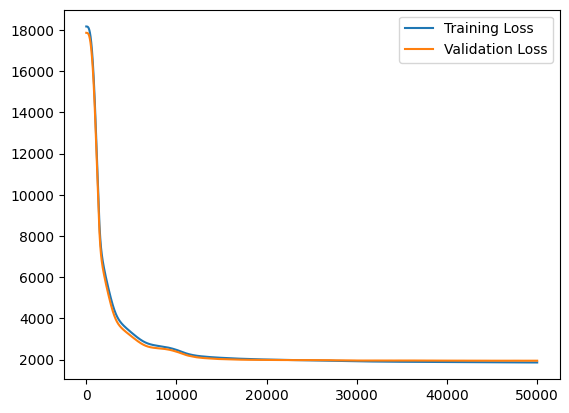

In [309]:
import matplotlib.pyplot as plt

print(training_loss.shape, validation_loss.shape)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [310]:
import pickle

df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth')
model.eval()

index = df['id']
df = df.drop(['id'], axis=1)
X = pre.encoder(df)
X = pre.standardize(X, scaler=pickle.load(open('scaler.pkl', 'rb')))
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

/var/folders/64/cy9kvd894_bfkfb71dsbxt2w0000gn/T/ipykernel_61623/228361571.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('mlp_model.pth')
